# Elliptic tutorial 

In this hands-on Python tutorial, we'll delve into an intriguing dataset that captures the dynamics of transactions within a blockchain network. Our goal will be to prepare this data for training machine learning models using the powerful PyTorch and PyTorch Lightning frameworks. By the end of this tutorial, you'll have a solid foundation for training machine learning models on this dataset. This foundation sets the stage for exciting applications such as: Fraud detection, Transaction pattern analysis, Blockchain network behavior prediction. Let's get started!

## Dataset background
The dataset description originates from [Kaggle Elliptic Dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) and [GitHub Elliptic++ Dataset](https://github.com/git-disl/EllipticPlusPlus/tree/main?tab=readme-ov-file). The dataset consist of two parts:

* **Actor dataset**: this dataset consists of 822k wallet addresses to enable the detection of illicit addresses (actors) in the Bitcoin network by leveraging graph data.
* **Transaction dataset**: This anonymized dataset - with over 200k transactions - is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.


The following figure shows the schematic of the dataset as a graph ([source](https://github.com/git-disl/EllipticPlusPlus/blob/main/images/actorvizaddrtx.jpg)).
Note that this is the graph with both wallets and transactions.

![Schematic visualization of the Address-Transaction graph](actorvizaddrtx.jpg)

We describe how the dataset is structured which enables us to develop models that detect, for example, fraudulent transactions. 

## Transaction graph
We first describe the transaction graph from [Kaggle Elliptic Dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set). 

### Nodes and edges

The transaction graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class 1 (illicit). Twenty-one percent (42,019) are labelled class 2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.


#### Features

Each node in our dataset has 166 associated features.  Unfortunately, we can't disclose the full feature list but we can show categories of features.

One key feature is a time step (1 to 49) representing when a Bitcoin transaction was broadcast. These time steps are spaced approximately two weeks apart. Within each time step, a single connected component captures transactions appearing on the blockchain within three hours of one another. Note that no connections exist between different time steps.

The first 94 features provide localized transaction data. This includes the time step, input/output counts, fees, output volume, and averages like BTC received/spent by inputs/outputs, and average incoming/outgoing transaction counts for inputs/outputs.

The final 72 features are aggregates derived from transactions one hop away (backward/forward) from the central node. These include maximums, minimums, standard deviations, and correlation coefficients for the same localized data (input/output counts, fees, etc.).

#### Dataset files

The dataset consists of three files:

* **elliptic_txs_classes.csv:** Each node is labelled as a "licit" (0), "illicit" (1), or "unkonwn" (2) entity in the class column, the txId column is a unique identifier to the node.  
* **elliptic_txs_edgelist.csv:** A list of nodes who are connected. The file has two columns txID1 and txId2. 
* **elliptic_txs_features.csv:** A file with 171 columns with the first column the transaction id, and the other columns node features. 

For detailed statistics, please visit the Kaggle Data Explorer of the [Elliptic Data Set](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set). 

## Loading the data
We use the FinTorch.datasets library to load the [Elliptic Data Set](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set). The following code downloads the dataset:

In [2]:
# from fintorch.datasets import elliptic
from fintorch.datasets import elliptic

# Load the elliptic dataset
elliptic_dataset = elliptic.TransactionDataset('~/.fintorch_data')

Let's discuss the code line by line:

1. **Importing:** We import the elliptic module from the fintorch.datasets package. This module provides convenient access to the Elliptic Bitcoin Dataset.

2. **Loading the Dataset:** We create an instance of the elliptic.EllipticDataset class and store it in the dataset variable. This loads the dataset from Kaggle and places it in the .fintorch_data/ directory. The fintorch framework uses with the [Kaggle API](https://github.com/Kaggle/kaggle-api) to download datasets. Make sure you've followed the instructions in the fintorch documentation to set up your Kaggle API credentials for seamless data access.



With the dataset ready, let's examine its structure. 

We will render the transaction graph first. We will sample from the complete graph and display a sub-graph.

Start-node BFS:97438
Sub-graph nodes:584 


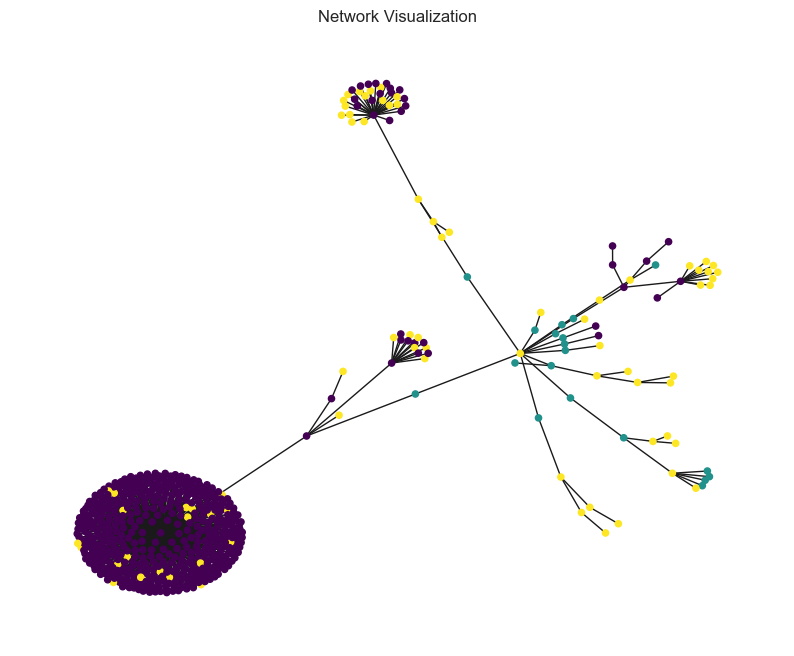

In [3]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

# Create a networkx dataset for plotting
graph = to_networkx(elliptic_dataset[0], to_undirected=True)

# Perform a breadth-first random walk from an illicit node
start_node = np.random.choice(np.where(elliptic_dataset[0].y.numpy() == 1)[0]) 
print(f"Start-node BFS:{start_node}")
subgraph_edges = nx.bfs_edges(graph, start_node, depth_limit=5)

# Create the sub-graph
subgraph = graph.edge_subgraph(subgraph_edges)

print(f"Sub-graph nodes:{len(subgraph.nodes())} ")

# Plot the network using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph)
nx.draw_networkx(subgraph, pos, with_labels=False, node_color=elliptic_dataset[0].y.numpy()[subgraph.nodes()], cmap='viridis', node_size=20)
plt.title('Network Visualization')
plt.axis('off')
plt.show()


Here a subgraph is shown. We sampled a random illicit node from the complete undirected graph. Then, we performe a breadth-first search to select nodes in the sub-graph. The colors represent the different types of nodes: licit, illicit, and unknown.

## Exploration


We convert the PyTorch DataSet into a Polars DataSet and perform basic exploratory data analysis:

In [4]:
type(elliptic_dataset)

fintorch.datasets.elliptic.TransactionDataset

We have a single graph thus we access element 0 in the data list:

In [5]:
elliptic_dataset[0]

Data(x=[203769, 167], edge_index=[2, 234355], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])

We have the following elements in the dataset:

* **x:** 203.769 nodes with 167 feature values
* **edge_index:** 234.355 pairs of nodes representing the edges between nodes. Note that we transformed the node names into indices. The mapping is stored in *elliptic_dataset.map_id*
* **train_mask:** a mask to indicate which nodes are used to train the model
* **val_mask:** a mask to indicate which nodes are used as validation set
* **test_mask:** a mask to indicate which nodes are used as a test set

In addition, we can query some properties of the dataset:

In [6]:
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edge features: {elliptic_dataset.num_edge_features}')
print(f'Number of classes: {elliptic_dataset.num_classes}')
print(f'Feature input matrix shape:{elliptic_dataset.x.shape}')
print(f'Edge index feature matrix shape:{elliptic_dataset.edge_index.shape}')
print(f'Label feature matrix shape:{elliptic_dataset.y.shape}')

Number of node features: 167
Number of edge features: 0
Number of classes: 3
Feature input matrix shape:torch.Size([203769, 167])
Edge index feature matrix shape:torch.Size([2, 234355])
Label feature matrix shape:torch.Size([203769])


In [7]:
import polars as pol

# Convert elliptic_dataset.y to a numpy array and then to a polars Series
y_series = pol.Series(elliptic_dataset.y.numpy())

# Calculate the fraction of each value in the distribution
fraction = y_series.value_counts() 
# Normalize the count column in fraction
fraction = fraction.with_columns(count_normalized = fraction['count'] / y_series.shape[0])


# Print the fraction of the value distribution
print(fraction)


shape: (3, 3)
┌─────┬────────┬──────────────────┐
│     ┆ count  ┆ count_normalized │
│ --- ┆ ---    ┆ ---              │
│ i64 ┆ u32    ┆ f64              │
╞═════╪════════╪══════════════════╡
│ 0   ┆ 42019  ┆ 0.206209         │
│ 2   ┆ 157205 ┆ 0.771486         │
│ 1   ┆ 4545   ┆ 0.022305         │
└─────┴────────┴──────────────────┘


The class distribution reveals a severe imbalance, with the "unknown" class dominating 80% of the dataset. This means that a naive model could achieve a misleadingly high accuracy of 80% simply by always predicting the majority class.  It's crucial to be aware of this imbalance when evaluating model performance on this dataset. 
Relying solely on accuracy could lead to the false impression that a model is performing well, when in reality it's merely taking advantage of the skewed distribution. 
To get a true understanding of model performance, consider metrics like precision, recall, and F1-score. 
Additionally, it's important to explore techniques for addressing class imbalance, such as resampling, cost-sensitive learning, or specialized loss functions.

## Simple model
While we'll demonstrate loading the Elliptic dataset into a simple graph neural network model and use accuracy as the evaluation metric for illustrative purposes, it's important to remember the class imbalance we just discussed. In this case, accuracy alone won't be a reliable measure of performance. Our main focus here is to showcase the loading process, not achieve optimal performance. 

This code defines a Graph Neural Network (GNN) model for processing data arranged in graphs. It takes node features and information about how the nodes connect as inputs. The model then stacks several layers that combine features from neighboring nodes, similar to how information spreads in a network. Finally, it outputs a new set of features for each node, potentially useful for classification tasks.

In [8]:
from torch import Tensor
import torch.nn as nn
import torch_geometric.nn as geom_nn

import torch.optim as optim


class GNNModel(nn.Module):

    def __init__(self, c_in: int, c_hidden: int, c_out: int, num_layers: int = 5, dp_rate: float = 0.1, **kwargs):
        """
        Initialize the Elliptical class.

        Args:
            c_in (int): Number of input channels.
            c_hidden (int): Number of hidden channels.
            c_out (int): Number of output channels.
            num_layers (int, optional): Number of GNN layers. Defaults to 5.
            dp_rate (float, optional): Dropout rate. Defaults to 0.1.
            **kwargs: Additional keyword arguments to be passed to the GNN layers.

        Returns:
            None
        """

        super().__init__()
        gnn_layer = geom_nn.GCNConv

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for _ in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor.
            edge_index (Tensor): Edge index tensor.

        Returns:
            Tensor: Output tensor.
        """

        for l in self.layers:
            if isinstance(l, geom_nn.MessagePassing):
                # In case of a geom layer, also pass the edge_index list
                x = l(x, edge_index)
            else:
                x = l(x)

        return x

The following code builds on the GNN model by turning it into a PyTorch Lightning module for training and evaluation. We define a GNN class that trains the model to predict the class of individual nodes in a graph. During training, we calculate accuracy and loss on a subset of nodes (masks) and update the model weights to minimize the loss. We also track the accuracy on validation and test sets to monitor the model's performance.

In [9]:
import torchmetrics
import pytorch_lightning as pl

class GNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)

        self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Get the mask 
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"

        # Calculate the loss for the mask
        loss = self.loss_module(x[mask], data.y[mask].long())
        pred = x[mask].argmax(dim=-1)
        
        return loss, pred, data.y[mask]

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.05)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, preds, y = self.forward(batch, mode="train")

        # log step metric
        self.accuracy(preds, y)
        self.log('train_acc_step', self.accuracy)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self.forward(batch, mode="val")

        # log step metric
        self.accuracy(preds, y)
        self.log('val_acc_step', self.accuracy)

    def test_step(self, batch, batch_idx):
        loss, preds, y = self.forward(batch, mode="test")

        # log step metric
        self.accuracy(preds, y)
        self.log('test_acc_step', self.accuracy)


The following code sets up the training process for our model. It prepares the graph dataset for training using a DataLoader, creates the GNN model, configures a PyTorch Lightning trainer to manage the training process on a GPU, trains the model, tests its performance on a test set, and finally returns the trained GNN model.

In [10]:
from torch_geometric.loader import DataLoader

def train_node_classifier(dataset, **model_kwargs):
    node_data_loader = DataLoader(dataset, batch_size = 1)

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(accelerator="cpu",
                         devices=1,
                         max_epochs=10,
                         enable_progress_bar=False) # False because epoch size is 1
    
    # Note: the dimensions are specific for the Elliptic dataset
    model = GNN(c_in=167, c_out=3, **model_kwargs)
    trainer.fit(model, train_dataloaders=node_data_loader, val_dataloaders=node_data_loader)

    # Test best model on the test set
    trainer.test(model, node_data_loader, verbose=True)


    return model

Here we call the code to train the model

In [11]:
node_gnn_model = train_node_classifier(dataset=elliptic_dataset,
                                                        c_hidden=16,
                                                        num_layers=5,
                                                        dp_rate=0.1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mboersma/Documents/AI4FinTech/FinTorch/.conda/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/mboersma/Documents/AI4FinTech/FinTorch/.conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type               | Params
-------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_step         0.8072921633720398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/mboersma/Documents/AI4FinTech/FinTorch/.conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


The training ran on a GPU and successfully trained your GNN model with 241,000 parameters. It reached the maximum of 1000 epochs. On the test data, the model achieved an accuracy of around 80.7%. Note that this accuracy level is misleading! 
Let's check what it actually predicts with the following code:

In [12]:
import torch
import polars as pol

output = node_gnn_model.model(elliptic_dataset.x, elliptic_dataset.edge_index)
# Assuming your tensor is named 'tensor'
argmax_tensor = torch.argmax(output, dim=1)

# Convert elliptic_dataset.y to a numpy array and then to a polars Series
y_series = pol.Series(argmax_tensor.numpy())

# Calculate the fraction of each value in the distribution
fraction = y_series.value_counts() 
# Normalize the count column in fraction
fraction = fraction.with_columns(count_normalized = fraction['count'] / y_series.shape[0])

# Print the fraction of the value distribution
print(fraction)

shape: (3, 3)
┌─────┬────────┬──────────────────┐
│     ┆ count  ┆ count_normalized │
│ --- ┆ ---    ┆ ---              │
│ i64 ┆ u32    ┆ f64              │
╞═════╪════════╪══════════════════╡
│ 1   ┆ 1853   ┆ 0.009094         │
│ 0   ┆ 13150  ┆ 0.064534         │
│ 2   ┆ 188766 ┆ 0.926373         │
└─────┴────────┴──────────────────┘


The model only predicts a single class and achieves high levels of accuracy!

## The Actor-Transaction graph
Here we discuss the Elliptic++ dataset [GitHub Elliptic++ Dataset](https://github.com/git-disl/EllipticPlusPlus/tree/main?tab=readme-ov-file). This includes transactions and wallets, where the wallet/actor can be illicit, licit, or unknown status. Each actor sends transactions in the networks, some of which are illicit, licit, or unknown status.
Compared to the previous graph, we know have the actors/wallets as a new set of nodes in the graph structure. This results in a Bipartite graph which we want to analyze using Pytorch Geometric. Therefore, the dataset returned is of type HeteroData, and here we show how to build a simple Graph Neural Network for HeteroData. Let's first discuss the features of the actor/wallet dataset:

### Actor features:

| Feature | Description |
|---|---|
| **Transaction related** | |
| BTCtransacted | Total BTC transacted (sent+received) |
| BTCsent | Total BTC sent |
| BTCreceived | Total BTC received |
| Fees | Total fees in BTC |
| Feesshare | Total fees as share of BTC transacted |
| **Time related** | |
| Blockstxs | Number of blocks between transactions |
| Blocksinput | Number of blocks between being an input address |
| Blocksoutput | Number of blocks between being an output address |
| Addr interactions | Number of interactions among addresses<br>5 values: total, min, max, mean, median |
| Class | Class label: {illicit, licit, unknown} |
| **Transaction related** | |
| Txstotal | Total number of blockchain transactions |
| TxSinput | Total number of dataset transactions as input address |
| TxSoutput | Total number of dataset transactions as output address |
| **Time related** | |
| Timesteps | Number of time steps transacting in |
| Lifetime | Lifetime in blocks |
| Block first | Block height first transacted in |
| Blocklast | Block height last transacted in |
| Block first sent | Block height first sent in |
| Block first receive | Block height first received in |
| Repeat interactions | Number of addresses transacted with multiple times<br>single value |

In [13]:
from fintorch.datasets import ellipticpp

# Load the elliptic dataset
actor_transaction_graph = ellipticpp.TransactionActorDataset('~/.fintorch_data')
actor_transaction_graph[0]

/Users/mboersma/Documents/AI4FinTech/FinTorch/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Start download from HuggingFace...


100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


HeteroData(
  wallets={
    x=[1268260, 55],
    y=[1268260],
    train_mask=[1268260],
    val_mask=[1268260],
    test_mask=[1268260],
  },
  transactions={
    x=[203769, 182],
    y=[203769],
    train_mask=[203769],
    val_mask=[203769],
    test_mask=[203769],
  },
  (transactions, to, transactions)={ edge_index=[2, 234355] },
  (transactions, to, wallets)={ edge_index=[2, 837124] },
  (wallets, to, transactions)={ edge_index=[2, 477117] },
  (wallets, to, wallets)={ edge_index=[2, 2868964] }
)

## Simple hetero model


In [14]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


data = actor_transaction_graph[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=4)
model = to_hetero(model, data.metadata(), aggr='sum')
print(data.metadata())
model

(['wallets', 'transactions'], [('transactions', 'to', 'transactions'), ('transactions', 'to', 'wallets'), ('wallets', 'to', 'transactions'), ('wallets', 'to', 'wallets')])


GraphModule(
  (conv1): ModuleDict(
    (transactions__to__transactions): SAGEConv((-1, -1), 64, aggr=mean)
    (transactions__to__wallets): SAGEConv((-1, -1), 64, aggr=mean)
    (wallets__to__transactions): SAGEConv((-1, -1), 64, aggr=mean)
    (wallets__to__wallets): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (transactions__to__transactions): SAGEConv((-1, -1), 4, aggr=mean)
    (transactions__to__wallets): SAGEConv((-1, -1), 4, aggr=mean)
    (wallets__to__transactions): SAGEConv((-1, -1), 4, aggr=mean)
    (wallets__to__wallets): SAGEConv((-1, -1), 4, aggr=mean)
  )
)

We define a Graph Neural Network (GNN) model capable of processing graphs. The GNN class we construct takes hidden and output feature dimensions as input and sets up a two-layer GNN architecture using SAGEConv layers. The forward method outlines how node features and graph connectivity information are processed through these layers to learn new feature representations for the nodes.

Next, we instantiate this GNN and convert it to work with a heterogeneous graph using the to_hetero function. A heterogeneous graph contains different types of nodes (like wallets and transactions) and edges (representing relationships between them). This conversion likely creates multiple specialized SAGEConv layers within our model, one for each type of edge relationship in the graph. Finally, we inspect the graph structure (node and edge types) and the structure of our resulting GNN module, including its specialized convolutions.

Next we show a simple forward pass through the model using the HeteroData dataset.

In [15]:
with torch.no_grad(): 
     out = model(data.x_dict, data.edge_index_dict)
     print(out)

{'wallets': tensor([[-113535.2812,  -74329.2422,   45409.6758,  -94579.9453],
        [ -50303.4219,  -13025.6641,     346.5488,  -94239.5312],
        [ -50303.4219,  -13025.6641,     346.5488,  -94239.5312],
        ...,
        [-104698.8438,  -87246.5391,   19619.0117, -103628.6484],
        [ -63982.3906, -102960.6484,   46003.9727,  -62574.2070],
        [ -30502.6211,   -7807.0156,   13661.2090,  -50766.6875]]), 'transactions': tensor([[188231.0000,  11931.6641, -85291.6016, 123704.8047],
        [187656.6406,   8461.1367, -87172.2422, 128185.3438],
        [174234.5469,  61235.7891, -75931.0000, 128750.8438],
        ...,
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]])}


We start by using with torch.no_grad() to temporarily disable gradient calculations within the block of code that follows. This is a common technique for improving efficiency and reducing memory usage during inference when we don't need to update the model's parameters. Next, we pass our input data (data.x_dict and data.edge_index_dict) to the GNN model and store the result in the out variable. Finally, we print the out variable to inspect the output generated by the model.

## Conclusion
In this hands-on Python tutorial, we've dived into an intriguing blockchain transaction dataset. We explored how to prepare this data for machine learning models using the powerful PyTorch Geometric and PyTorch Lightning frameworks.  By following these steps, you've built a solid foundation for training various machine learning models on this dataset. This opens doors to exciting applications like fraud detection, transaction pattern analysis, and even predicting blockchain network behavior. Remember, practice and exploration are key to mastering these techniques.  Feel free to revisit this dataset and try your hand at fraud detection or other applications that interest you!

# References
- Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics. In Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD ’23), August 6–10, 2023, Long Beach, CA, USA. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3580305.3599803